<a href="https://colab.research.google.com/github/gracelcai/career-launch-group-13/blob/main/ExerciseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Pose Coordinates with MediaPipe

## Setup

Make sure you upload your video file into files

In [95]:
# Installing MediaPipe
!pip install -q mediapipe==0.10.0
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [96]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

## Get Frames

In [97]:
# upload video file from https://www.kaggle.com/datasets/hasyimabdillah/workoutfitness-video
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving squat_10.mp4 to squat_10 (2).mp4


In [98]:
import cv2
# getting video
video = cv2.VideoCapture(filename)

In [99]:
from IPython.display import HTML
from base64 import b64encode

# displaying video
print("Your video:\n")
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Your video:



In [100]:
# displaying frames per second
fps = video.get(cv2.CAP_PROP_FPS)
print('frame per seconds = ', fps)

frame per seconds =  23.976023976023978


your starting frame:



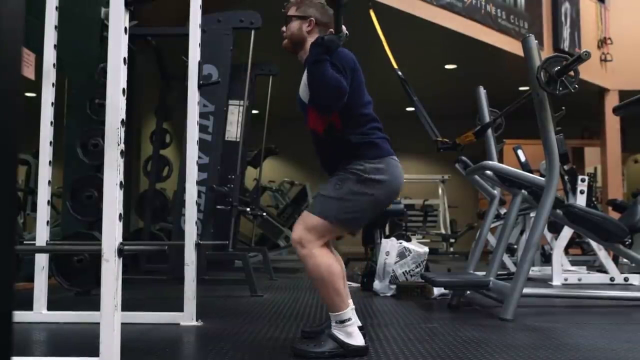



your ending frame:



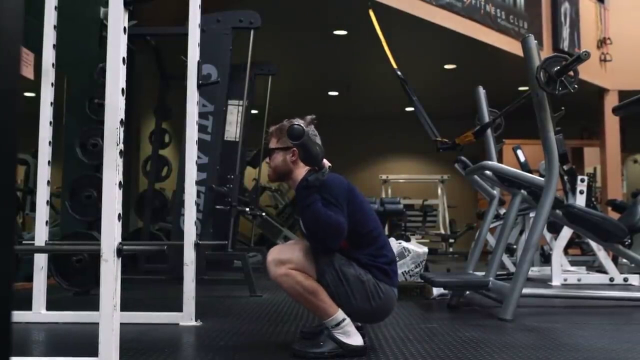

In [101]:
#@markdown enter the frame of your starting pose you would like to choose based on the time stamp in the video
from google.colab.patches import cv2_imshow
start_minutes = 0 # @param {type: "integer"}
start_seconds = 1 # @param {type: "integer"}

# getting frame from time stamp of video
start_t_msec = 1000 * (start_minutes * 60 + start_seconds)
video.set(cv2.CAP_PROP_POS_MSEC, start_t_msec)
start_ret, start_frame = video.read()

start_frame = cv2.resize(start_frame, (0, 0), fx = 0.5, fy = 0.5)

# displaying starting frames
print("your starting frame:\n")
cv2_imshow(start_frame)

#@markdown enter the frame of your ending pose that you would like to choose based on the time stamp in the video
from google.colab.patches import cv2_imshow
end_minutes = 0 # @param {type: "integer"}
end_seconds = 3 # @param {type: "integer"}

# getting frame from time stamp of video
end_t_msec = 1000 * (end_minutes * 60 + end_seconds)
video.set(cv2.CAP_PROP_POS_MSEC, end_t_msec)
end_ret, end_frame = video.read()
end_frame = cv2.resize(end_frame, (0, 0), fx = 0.5, fy = 0.5)

# displaying ending frame
print("\n\nyour ending frame:\n")
cv2_imshow(end_frame)

In [102]:
cv2.imwrite('start_frame.jpg', start_frame)
cv2.imwrite('end_frame.jpg', end_frame)

True

## Detecting Starting Pose

starting frame:



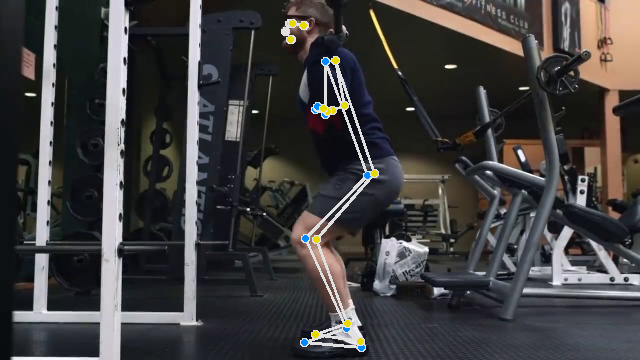

In [103]:
# STEP 1: Import the necessary modules.
import mediapipe as start_mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = start_mp.Image.create_from_file("start_frame.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
print("starting frame:\n")
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

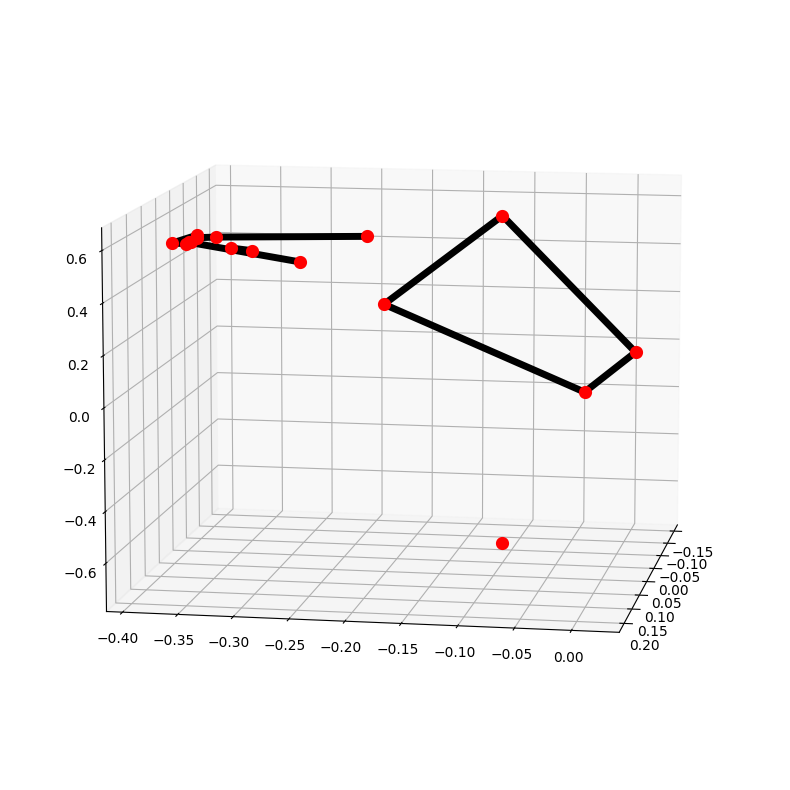

In [104]:
# For static images:
start_mp_drawing = start_mp.solutions.drawing_utils
start_mp_drawing_styles = start_mp.solutions.drawing_styles
start_mp_pose = start_mp.solutions.pose
BG_COLOR = (192, 192, 192) # gray
with start_mp_pose.Pose(
    static_image_mode = True,
    model_complexity = 2,
    enable_segmentation = True,
    min_detection_confidence = 0.5) as pose:

  image = cv2.imread("start_frame.jpg")
  image_height, image_width, _ = image.shape
  # Convert the BGR image to RGB before processing.
  start_results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  #print(
  #    f'Nose coordinates: ('
  #    f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
  #    f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
  #)

  annotated_image_start = image.copy()
  # Draw segmentation on the image.
  # To improve segmentation around boundaries, consider applying a joint
  # bilateral filter to "results.segmentation_mask" with "image".
  condition = np.stack((start_results.segmentation_mask,) * 3, axis=-1) > 0.1
  bg_image = np.zeros(image.shape, dtype=np.uint8)
  bg_image[:] = BG_COLOR
  annotated_image_start = np.where(condition, annotated_image_start, bg_image)

  # Draw pose landmarks on the image.
  start_mp_drawing.draw_landmarks(
      annotated_image_start,
      start_results.pose_landmarks,
      start_mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec = start_mp_drawing_styles.get_default_pose_landmarks_style())
  cv2.imwrite('/tmp/annotated_image_start.jpg', annotated_image_start)

  # cv2_imshow(annotated_image_start)

  # Plot pose world landmarks.
  start_mp_drawing.plot_landmarks(
      start_results.pose_world_landmarks, start_mp_pose.POSE_CONNECTIONS)

## Detecting Ending Pose

ending frame:



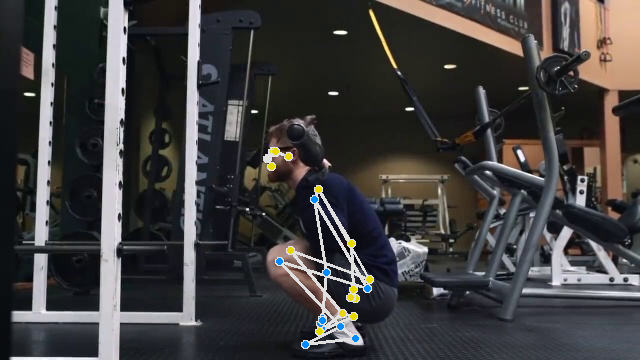

In [105]:
# STEP 1: Import the necessary modules.
import mediapipe as end_mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = end_mp.Image.create_from_file("end_frame.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
print("ending frame:\n")
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


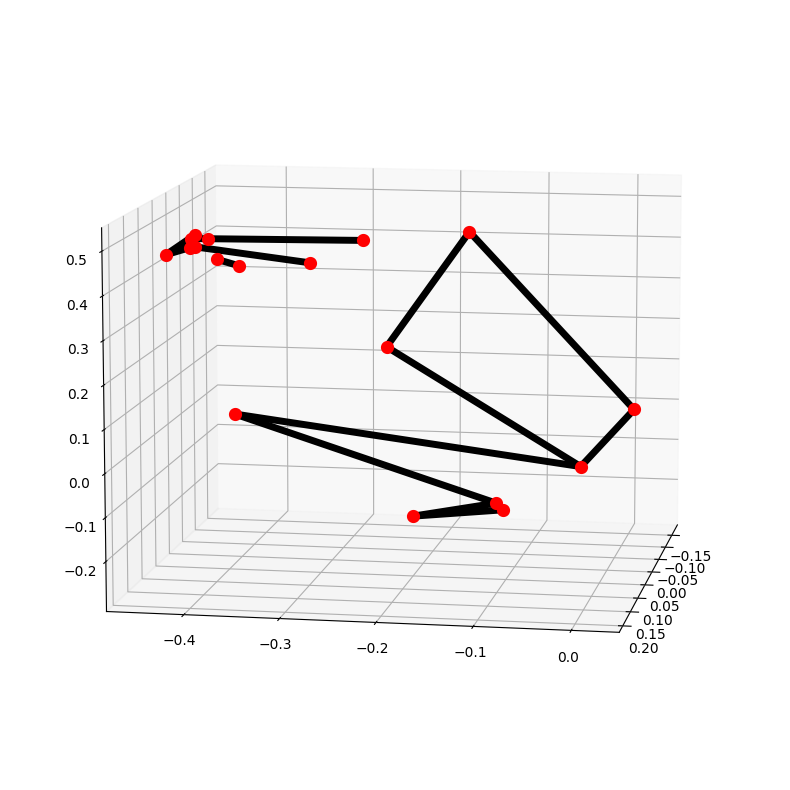

In [106]:
# For static images:
end_mp_drawing = end_mp.solutions.drawing_utils
end_mp_drawing_styles = end_mp.solutions.drawing_styles
end_mp_pose = end_mp.solutions.pose
BG_COLOR = (192, 192, 192) # gray
with end_mp_pose.Pose(
    static_image_mode = True,
    model_complexity = 2,
    enable_segmentation = True,
    min_detection_confidence = 0.5) as pose:

  image = cv2.imread("end_frame.jpg")
  image_height, image_width, _ = image.shape
  # Convert the BGR image to RGB before processing.
  end_results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  #print(
  #    f'Nose coordinates: ('
  #    f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
  #    f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
  #)

  annotated_image = image.copy()
  # Draw segmentation on the image.
  # To improve segmentation around boundaries, consider applying a joint
  # bilateral filter to "results.segmentation_mask" with "image".
  condition = np.stack((end_results.segmentation_mask,) * 3, axis=-1) > 0.1
  bg_image = np.zeros(image.shape, dtype=np.uint8)
  bg_image[:] = BG_COLOR
  annotated_image = np.where(condition, annotated_image, bg_image)

  # Draw pose landmarks on the image.
  end_mp_drawing.draw_landmarks(
      annotated_image,
      end_results.pose_landmarks,
      end_mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec = end_mp_drawing_styles.get_default_pose_landmarks_style())
  cv2.imwrite('/tmp/annotated_image_end.jpg', annotated_image)

  # Plot pose world landmarks.
  end_mp_drawing.plot_landmarks(
      end_results.pose_world_landmarks, end_mp_pose.POSE_CONNECTIONS)

# print("\n\nending frame:\n")
# end_results = show_pose_landmarks("end_frame.jpg")

## Finding Coordinates

In [107]:
start_frame_hight, start_frame_width, _ = start_frame.shape
end_frame_hight, end_frame_width, _ = end_frame.shape
# Note: the times 100 might be wrong idk

# scaling factors
x_scale = 100
y_scale = 100
z_scale = 254

# Getting XYZ-coordinates of nose
x1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].x * x_scale
x2_coordinate = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].x * x_scale
y1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].y * y_scale
y2_coordinate = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].y * y_scale
z1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].z * z_scale
z2_coordinate = start_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].z * z_scale
print("Initial Coordinates of Nose:")
print("x:", x1_coordinate)
print("y:", y1_coordinate)
print("z:", z1_coordinate)

print("\nFinal Coordinates of Nose:")
print("x:", x2_coordinate)
print("y:", y2_coordinate)
print("z:", z2_coordinate)
x_scale, y_scale

Initial Coordinates of Nose:
x: 44.64122653007507
y: 8.830526471138
z: -8.21917188167572

Final Coordinates of Nose:
x: 41.75189137458801
y: 44.03173327445984
z: -8.21917188167572


(100, 100)

In [108]:
import math
# Finding distance in specified axis (for different parts)
def xyz_distances(part_1, part_2, axis):
  if(axis == 'x'):
    return (part_2.x - part_1.x) * x_scale
  elif(axis == 'y'):
    return (part_2.y - part_1.y) * y_scale
  else:
    return (part_2.z - part_1.z) * z_scale

# Finding distance in specified axis (for same part)
def landmark(start_position, end_position, axis):
  if(axis == 'x'):
    return (end_position.x - start_position.x) * x_scale
  elif(axis == 'y'):
    return (end_position.y - start_position.y) * y_scale
  else:
    return (end_position.z - start_position.z) * z_scale

# Finding 3D distances
def distance_3D(part_1, part_2):
  x = (part_2.x - part_1.x) * x_scale
  y = (part_2.y - part_1.y) * y_scale
  z = (part_2.z - part_1.z) * z_scale
  return math.sqrt(x**2 + y**2 + z**2)

# find angle between 3 landmarks
def angle(part_1, part_2, part_3):
  a_mag = math.sqrt(((part_1.x - part_2.x) * x_scale)**2 + ((part_1.y - part_2.y) * y_scale)**2 + ((part_1.z - part_2.z) * z_scale)**2)
  b_mag = math.sqrt(((part_3.x - part_2.x) * x_scale)**2 + ((part_3.y - part_2.y) * y_scale)**2 + ((part_3.z - part_2.z) * z_scale)**2)
  a_dot_b = ((part_1.x - part_2.x) * (part_3.x - part_2.x) * x_scale**2) + ((part_1.y - part_2.y) * (part_3.y - part_2.y) * y_scale**2) + ((part_1.z - part_2.z) * (part_3.z - part_2.z) * z_scale**2)
  angle = (math.acos(a_dot_b / (a_mag * b_mag))) * (180 / math.pi)
  return angle

def mid_angle(right_knee, left_knee, right_hip, left_hip):
  mid_hip_x = (left_hip.x + right_hip.x)/2.0
  mid_hip_y = (left_hip.y + right_hip.y)/2.0
  mid_hip_z = (left_hip.z + right_hip.z)/2.0

  a_mag = math.sqrt((right_knee.x - mid_hip_x)**2 + (right_knee.y - mid_hip_y)**2 + (right_knee.z - mid_hip_z)**2)
  b_mag = math.sqrt((left_knee.x - mid_hip_x)**2 + (left_knee.y - mid_hip_y)**2 + (left_knee.z - mid_hip_z)**2)
  a_dot_b = ((right_knee.x - mid_hip_x)*(left_knee.x - mid_hip_x)) + ((right_knee.y - mid_hip_y)*(left_knee.y - mid_hip_y)) + ((right_knee.z - mid_hip_z)*(left_knee.z - mid_hip_z))
  angle = (math.acos(a_dot_b / (a_mag * b_mag))) * (180 / math.pi)
  return angle

def distance_3D_avg(part_1, part_2a, part_2b):
  x = (((part_2a.x + part_2b.x)/2) - part_1.x) * x_scale
  y = (((part_2a.y + part_2b.y)/2) - part_1.y) * y_scale
  z = (((part_2a.z + part_2b.z)/2) - part_1.z) * z_scale
  return math.sqrt(x**2 + y**2 + z**2)

def distance_xyz_avg(part_1, part_2a, part_2b):
  x = (((part_2a.x + part_2b.x)/2) - part_1.x) * x_scale
  y = (((part_2a.y + part_2b.y)/2) - part_1.y) * y_scale
  z = (((part_2a.z + part_2b.z)/2) - part_1.z) * z_scale
  return x, y, z

def scaled_landmark(position):
  x = position.x * x_scale
  y = position.y * y_scale
  z = position.z * z_scale
  return x, y, z

In [109]:
start_pos_rh = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_HIP]
end_pos_rh = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.RIGHT_HIP]

print("Right Hip shift:")
print("x distance:", landmark(start_pos_rh, end_pos_rh, 'x'))
print("y distance:", landmark(start_pos_rh, end_pos_rh, 'y'))
print("z distance:", landmark(start_pos_rh, end_pos_rh, 'z'))


start_pos_ra = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_ANKLE]
end_pos_ra = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.RIGHT_ANKLE]

print("\nRight Ankle shift:")
print("x distance:", landmark(start_pos_ra, end_pos_ra, 'x'))
print("y distance:", landmark(start_pos_ra, end_pos_ra, 'y'))
print("z distance:", landmark(start_pos_ra, end_pos_ra, 'z'))

start_pos_rk = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_KNEE]
end_pos_rk = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.RIGHT_KNEE]

print("\nRight Knee shift:")
print("x distance:", landmark(start_pos_rk, end_pos_rk, 'x'))
print("y distance:", landmark(start_pos_rk, end_pos_rk, 'y'))
print("z distance:", landmark(start_pos_rk, end_pos_rk, 'z'))


# 3D
print("\n\nStarting Distance Right Hip to Right Knee:")
print(distance_3D(start_pos_rh, start_pos_rk))

print("\nEnding distance Right Hip to Right Knee:")
print(distance_3D(end_pos_rh, end_pos_rk))

print("\n\nStarting Angle between Right Hip, Right Knee, Right Ankle:")
print(angle(start_pos_rh, start_pos_rk, start_pos_ra), "degrees")

print("\nEnding Angle between Right Hip, Right Knee, Right Ankle:")
print(angle(end_pos_rh, end_pos_rk, end_pos_ra), "degrees")

start_pos_lh = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.LEFT_HIP]
end_pos_lh = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.LEFT_HIP]
start_pos_lk = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.LEFT_KNEE]
end_pos_lk = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.LEFT_KNEE]

print("\n\nStarting Mid Angle:")
print(mid_angle(start_pos_rk, start_pos_lk, start_pos_rh, start_pos_lh), " degrees")
print("\nEnding Mid Angle:")
print(mid_angle(end_pos_rk, end_pos_lk, end_pos_rh, end_pos_lh), " degrees")

Right Hip shift:
x distance: -0.8850932121276855
y distance: 29.23288643360138
z distance: 4.105789691209793

Right Ankle shift:
x distance: -0.8925020694732666
y distance: -2.5975584983825684
z distance: 51.280655920505524

Right Knee shift:
x distance: -4.437914490699768
y distance: 3.1906962394714355
z distance: 33.758405297994614


Starting Distance Right Hip to Right Knee:
20.12790256888238

Ending distance Right Hip to Right Knee:
32.66726489576368


Starting Angle between Right Hip, Right Knee, Right Ankle:
138.34192133968372 degrees

Ending Angle between Right Hip, Right Knee, Right Ankle:
119.9722299611731 degrees


Starting Mid Angle:
55.013531360148676  degrees

Ending Mid Angle:
103.89331552278587  degrees


# Turn data into tensors

In [110]:
import torch
import numpy as np

# list of corresponding landmark indices for distance calculation
pose_landmark = start_mp_pose.PoseLandmark
distances_dict = [
    (pose_landmark.LEFT_SHOULDER, pose_landmark.LEFT_WRIST),
    (pose_landmark.RIGHT_SHOULDER, pose_landmark.RIGHT_WRIST),
    (pose_landmark.LEFT_HIP, pose_landmark.LEFT_ANKLE),
    (pose_landmark.RIGHT_HIP, pose_landmark.RIGHT_ANKLE),
    (pose_landmark.LEFT_HIP, pose_landmark.LEFT_WRIST),
    (pose_landmark.RIGHT_HIP, pose_landmark.RIGHT_WRIST),
    (pose_landmark.LEFT_SHOULDER, pose_landmark.LEFT_ANKLE),
    (pose_landmark.RIGHT_SHOULDER, pose_landmark.RIGHT_ANKLE),
    (pose_landmark.LEFT_HIP, pose_landmark.RIGHT_WRIST),
    (pose_landmark.RIGHT_HIP, pose_landmark.LEFT_WRIST),
    (pose_landmark.LEFT_ELBOW, pose_landmark.RIGHT_ELBOW),
    (pose_landmark.LEFT_KNEE, pose_landmark.RIGHT_KNEE),
    (pose_landmark.LEFT_WRIST, pose_landmark.RIGHT_WRIST),
    (pose_landmark.LEFT_ANKLE, pose_landmark.RIGHT_ANKLE)
]

angles_dict = [
    (pose_landmark.RIGHT_ELBOW, pose_landmark.RIGHT_SHOULDER, pose_landmark.RIGHT_HIP),
    (pose_landmark.LEFT_ELBOW, pose_landmark.LEFT_SHOULDER, pose_landmark.LEFT_HIP),
    (pose_landmark.RIGHT_KNEE, -1, pose_landmark.LEFT_KNEE),
    (pose_landmark.RIGHT_HIP, pose_landmark.RIGHT_KNEE, pose_landmark.RIGHT_ANKLE),
    (pose_landmark.LEFT_HIP, pose_landmark.LEFT_KNEE, pose_landmark.LEFT_ANKLE),
    (pose_landmark.RIGHT_WRIST, pose_landmark.RIGHT_ELBOW, pose_landmark.RIGHT_SHOULDER),
    (pose_landmark.LEFT_WRIST, pose_landmark.LEFT_ELBOW, pose_landmark.LEFT_SHOULDER)
]
def get_landmark_tensor(landmarks):
  landmarks_tensor = torch.empty((0), dtype=torch.float)

  for landmark in landmarks:
    landmarks_tensor = torch.cat([landmarks_tensor, torch.tensor(scaled_landmark(landmark))], dim=0)
  return landmarks_tensor

def get_distances_tensor(landmarks):
  distances_tensor = torch.empty((0), dtype=torch.float)
  for (start, end) in distances_dict:
    distances_tensor = torch.cat([distances_tensor, torch.tensor(distance_3D(landmarks[start], landmarks[end])).unsqueeze(0)], dim=0)
  distances_tensor = torch.cat([distances_tensor,
                                torch.tensor([distance_3D_avg(landmarks[pose_landmark.LEFT_HIP],
                                                              landmarks[pose_landmark.LEFT_WRIST],
                                                              landmarks[pose_landmark.LEFT_ANKLE])])])
  distances_tensor = torch.cat([distances_tensor,
                                torch.tensor([distance_3D_avg(landmarks[pose_landmark.RIGHT_HIP],
                                                              landmarks[pose_landmark.RIGHT_WRIST],
                                                              landmarks[pose_landmark.RIGHT_ANKLE])])])
  return distances_tensor

def get_xyz_distances_tensor(landmarks):
  xyz_distances_tensor = torch.empty((0), dtype=torch.float)
  for (start, end) in distances_dict:
    # print(f"start: {start}, end: {end}")
    xyz_distances_tensor = torch.cat([xyz_distances_tensor,
                                      torch.tensor([xyz_distances(landmarks[start], landmarks[end], 'x'),
                                                   xyz_distances(landmarks[start], landmarks[end], 'y'),
                                                   xyz_distances(landmarks[start], landmarks[end], 'z')])], dim=0)
  xyz_distances_tensor = torch.cat([xyz_distances_tensor,
                                   torch.tensor(distance_xyz_avg(landmarks[pose_landmark.LEFT_HIP],
                                                              landmarks[pose_landmark.LEFT_WRIST],
                                                              landmarks[pose_landmark.LEFT_ANKLE]))])
  xyz_distances_tensor = torch.cat([xyz_distances_tensor,
                                    torch.tensor(distance_xyz_avg(landmarks[pose_landmark.RIGHT_HIP],
                                                              landmarks[pose_landmark.RIGHT_WRIST],
                                                              landmarks[pose_landmark.RIGHT_ANKLE]))])
  return xyz_distances_tensor

def get_angles_tensor(landmarks):
  angles_tensor = torch.empty((0), dtype=torch.float)
  # TODO: add angles into tensor
  for (start, middle, end) in angles_dict:
    if middle == -1:
      angles_tensor = torch.cat([angles_tensor, torch.tensor([mid_angle(landmarks[start], landmarks[end], landmarks[pose_landmark.LEFT_HIP], landmarks[pose_landmark.RIGHT_HIP])])])
    else:
      angles_tensor = torch.cat([angles_tensor, torch.tensor([angle(landmarks[start], landmarks[middle], landmarks[end])])])
  return angles_tensor

In [111]:
# start tensors
start_landmarks_tensor = get_landmark_tensor(start_results.pose_landmarks.landmark)
start_distances_tensor = get_distances_tensor(start_results.pose_landmarks.landmark)
start_xyz_distances_tensor = get_xyz_distances_tensor(start_results.pose_landmarks.landmark)
start_angles_tensor = get_angles_tensor(start_results.pose_landmarks.landmark)
print(f"start landmarks tensor: {start_landmarks_tensor}")
print(f"start distances tensor: {start_distances_tensor}, shape: {start_distances_tensor.shape}")
print(f"start xyz distances tensor: {start_xyz_distances_tensor}, shape: {start_xyz_distances_tensor.shape}")
print(f"start angles tensor: {start_angles_tensor}, shape: {start_angles_tensor.shape}")

start landmarks tensor: tensor([  44.6412,    8.8305,   -8.2192,   45.2512,    6.6642,  -15.4520,
          45.4733,    6.6197,  -15.4983,   45.6870,    6.5776,  -15.4688,
          45.2450,    6.6677,   -6.9209,   45.4574,    6.6313,   -7.0110,
          45.6820,    6.5806,   -7.0289,   47.5362,    7.0773,  -34.6938,
          47.5010,    7.1704,    3.8169,   45.4938,   10.9246,  -13.2313,
          45.4364,   10.9575,   -2.6819,   50.9971,   16.9488,  -54.5869,
          52.4027,   16.9330,   33.5462,   51.1339,   31.8247,  -90.8025,
          53.8116,   29.2454,   83.9323,   49.7233,   29.5644, -102.8994,
          51.8345,   29.8518,  123.5264,   49.5324,   29.7454, -111.2870,
          51.7395,   29.9239,  130.5568,   49.6478,   28.3716, -108.9868,
          50.9079,   29.3181,  124.9741,   49.6024,   28.1965, -102.0006,
          50.8899,   29.4211,  121.5771,   57.5414,   48.6762,  -27.3995,
          58.6167,   48.2924,   27.4075,   47.7776,   66.2643,  -25.9746,
          49.8

In [112]:
# end tensors
end_landmarks_tensor = get_landmark_tensor(end_results.pose_landmarks.landmark)
end_distances_tensor = get_distances_tensor(end_results.pose_landmarks.landmark)
end_xyz_distances_tensor = get_xyz_distances_tensor(end_results.pose_landmarks.landmark)
end_angles_tensor = get_angles_tensor(end_results.pose_landmarks.landmark)
print(f"end landmarks tensor: {end_landmarks_tensor}")
print(f"end distances tensor: {end_distances_tensor}")
print(f"end xyz distances tensor: {end_xyz_distances_tensor}")
print(f"end angles tensor: {end_angles_tensor}")

end landmarks tensor: tensor([ 41.7519,  44.0317, -13.8505,  42.5777,  42.2115, -19.2144,  42.7748,
         42.3437, -19.2500,  42.9800,  42.4611, -19.2548,  42.5740,  42.0562,
         -8.9390,  42.7572,  42.1107,  -9.0043,  42.9628,  42.1847,  -9.0361,
         45.0709,  43.5036, -35.2868,  45.0984,  43.4859,  11.4817,  42.3702,
         46.2650, -18.8718,  42.4575,  46.1771,  -5.7588,  49.6694,  55.0254,
        -58.3400,  50.0460,  52.8109,  37.2073,  50.7065,  75.5867, -73.6627,
         54.7977,  67.7608,  34.9829,  49.8063,  87.7444, -55.7599,  55.2897,
         80.4926,   3.8815,  49.5521,  90.3826, -62.5397,  55.4259,  82.7572,
         -0.2645,  49.3947,  88.9405, -61.4209,  55.0317,  82.8619,  -6.6353,
         49.8012,  88.0445, -54.5879,  54.8842,  82.6631,  -0.1905,  57.4062,
         80.0855, -31.5803,  57.7316,  77.5253,  31.5133,  43.7541,  72.5717,
        -39.6161,  45.4443,  69.6118,  60.7288,  53.2024,  90.5289,   0.7841,
         53.3977,  87.0771,  86.9605,  55.

In [113]:
# order of tensors: distances, xyz_distances, angles, landmarks
start_tensor = torch.cat([start_distances_tensor, start_xyz_distances_tensor, start_angles_tensor, start_landmarks_tensor])
end_tensor = torch.cat([end_distances_tensor, end_xyz_distances_tensor, end_angles_tensor, end_landmarks_tensor])
print(f"full start tensor: {start_tensor}, shape: {start_tensor.shape}")
print(f"full end tensor: {end_tensor}, shape: {end_tensor.shape}")

full start tensor: tensor([ 4.9949e+01,  9.0905e+01,  4.4596e+01,  4.2422e+01,  7.8273e+01,
         9.8107e+01,  8.4440e+01,  7.2797e+01,  1.5220e+02,  1.3195e+02,
         1.7477e+02,  5.2987e+01,  2.2644e+02,  5.0356e+01,  3.3964e+01,
         5.3729e+01, -1.2738e+00,  1.2616e+01, -4.8313e+01, -5.6823e-01,
         1.2919e+01,  8.9980e+01, -3.3484e+00,  4.2603e+01,  1.2749e+01,
        -4.3265e+00,  4.1382e+01,  8.2723e+00, -7.8182e+00, -1.9112e+01,
        -7.5500e+01, -6.7823e+00, -1.8441e+01,  9.6119e+01,  3.1960e+00,
         7.4330e+01,  3.9936e+01,  1.8875e+00,  7.2742e+01,  2.1336e+00,
        -5.7069e+00, -1.8824e+01,  1.5093e+02, -8.8935e+00, -1.8728e+01,
        -1.3031e+02,  2.6776e+00, -2.5793e+00,  1.7473e+02,  2.1046e+00,
         1.5683e-01,  5.2945e+01,  2.1112e+00,  2.8740e-01,  2.2643e+02,
         9.7132e-02, -1.6046e+00,  5.0330e+01, -5.5833e+00,  1.1746e+01,
        -3.1375e+01, -5.5544e+00,  1.1471e+01,  5.2196e+01,  8.7097e+01,
         1.0800e+02,  5.5014e+01

# Make prediction using start and end tensors

## Import Model

In [114]:
# upload model file
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving classificationModel.pth to classificationModel (4).pth


In [115]:
from torch import nn

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# initialize model with state dict from file
class ExerciseModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)

exercise_model = ExerciseModel(input_features=start_tensor.size(dim=0),
                                   hidden_units=200,
                                   output_features=10).to(device)

exercise_model.load_state_dict(torch.load(f=filename))

<All keys matched successfully>

In [116]:
class_names = ["jumping_jacks_down", "jumping_jacks_up",
               "pullups_down", "pullups_up",
               "pushups_down", "pushups_up",
               "situp_down", "situp_up",
               "squats_down", "squats_up"]

# make predictions with loaded model
exercise_model.eval()
with torch.inference_mode():
  start_logit = exercise_model(start_tensor)
  start_preds = torch.softmax(start_logit.squeeze(), dim=0)
  start_pred = torch.softmax(start_logit.squeeze(), dim=0).argmax(dim=0)

  print(f"---Starting frame---\nPrediction: {class_names[start_pred]}, Accuracy: {start_preds[start_pred] * 100:.2f}%")

  end_logit = exercise_model(end_tensor)
  end_preds = torch.softmax(end_logit.squeeze(), dim=0)
  end_pred = torch.softmax(end_logit.squeeze(), dim=0).argmax(dim=0)

  print(f"---Ending frame---\nPrediction: {class_names[end_pred]}, Accuracy: {end_preds[end_pred] * 100:.2f} %")

---Starting frame---
Prediction: squats_up, Accuracy: 81.89%
---Ending frame---
Prediction: squats_up, Accuracy: 74.49 %


# Old Stuff

## Setup:

In [ ]:
# import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

## Preparing data:

In [ ]:
# Setup training data
train_data = # TODO

test_data = # TODO

In [ ]:
# Turn train dataset into DataLoader
from torch.utils.data import DataLoader

# setup batch size hyperparameter
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                           batch_size = BATCH_SIZE,
                           shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

train_dataloader, test_dataloader

## Creating the Model:

In [ ]:
from torch import nn
class Exercise_Model(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        # TODO
    )

  def forward(self, x):
    return # TODO

In [ ]:
# setup model

model = Exercise_Model(
    input_shape = ,
    hidden_units = ,
    output_shape =
).to(device)

model

In [ ]:
##### POSSIBLY WRONG
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measures how wrong model is TODO: are we using CrossEntropyLoss?
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1) # TODO: Do we want to use SGD?

## Training and Testing Functions

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """ Performs a training with model trying to learn on data_loader"""
  train_loss, train_acc = 0, 0

  model.train()

  # Add loop to loop through training batches
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    train_acc += accuracy_fn(y_true = y,
                             y_pred = y_pred.argmax(dim = 1)) # from logits -> prediction labels

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #TODO: change this up (below)
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | train acc: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs testing loop step on model going over data_loader"""
  test_loss, test_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))


    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [ ]:
# If we want to time our model?
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
  """
  Prints difference between start and end time
  """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

## Training and Testing the Model:

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set seed and start timer
torch.manual_seed(42)
train_start = timer()

# set number of epochs (small for faster training time)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")

  # Training
  train_loss = 0

  # Add loop to loop through training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model.train()

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  # Testing
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:

      test_pred = model(X_test)

      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim = 1))

    test_loss /= len(test_dataloader)

    test_acc /= len(test_dataloader)

  # print whats happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_end = timer()
train_time = print_train_time(start = train_start,
                              end = train_end,
                              device = str(next(model.parameters()).device))

## Evaluating Model:

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """ Returns dictionary containing results of model predicting on data_loader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):

      # Make predictions
      y_pred = model(X)

      # Accumulate loss and acc values per batch
      loss += loss_fn(y_pred, y)

      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))
    # scale loss and acc to find average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  # TODO: idk if __class__.__name__ is gonna be a thing or not
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}
# Calculate model 0 results on dataset
model_results = eval_model(model = model,
                           data_loader = test_dataloader,
                           loss_fn = loss_fn,
                           accuracy_fn = accuracy_fn,
                           device = device)
model_results

## Import Model

In [ ]:
# TODO: import model

## Use Model to Calculate Accuracy of Exercise

In [ ]:
# TODO: prepare data to be inputted into the model

In [ ]:
# TODO: input data into model and output result